In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
import plotly.express as px
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report, f1_score, ConfusionMatrixDisplay, silhouette_score

# Part 1: Forest Cover Type
## Section A:Data Exploration & Visualization
### Data Loading and Initial Exploration

In [20]:
# Load the dataset
df0 = pd.read_csv("treetypes.csv", index_col=0)
df = df0.reset_index()
# Display the first few rows of the dataset
print("First 5 rows of the dataset:")
df.head()

First 5 rows of the dataset:


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,label
0,2485,160,22,0,0,1595,236,238,121,532,...,0,0,0,0,0,0,0,0,0,3
1,2687,21,19,150,12,1276,204,196,123,1867,...,0,1,0,0,0,0,0,0,0,1
2,2324,236,36,495,182,806,135,243,226,882,...,0,0,0,0,0,0,0,0,0,3
3,3162,272,19,666,75,3436,166,242,213,2015,...,0,0,0,0,0,0,0,0,0,1
4,2605,223,11,277,5,750,206,251,180,1249,...,0,0,0,0,0,0,0,0,0,3


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 55 columns):
 #   Column                              Non-Null Count  Dtype
---  ------                              --------------  -----
 0   Elevation                           45000 non-null  int64
 1   Aspect                              45000 non-null  int64
 2   Slope                               45000 non-null  int64
 3   Horizontal_Distance_To_Hydrology    45000 non-null  int64
 4   Vertical_Distance_To_Hydrology      45000 non-null  int64
 5   Horizontal_Distance_To_Roadways     45000 non-null  int64
 6   Hillshade_9am                       45000 non-null  int64
 7   Hillshade_Noon                      45000 non-null  int64
 8   Hillshade_3pm                       45000 non-null  int64
 9   Horizontal_Distance_To_Fire_Points  45000 non-null  int64
 10  Wilderness_Area1                    45000 non-null  int64
 11  Wilderness_Area2                    45000 non-null  int64
 12  Wild

In [22]:
# Generate descriptive statistics
print("Descriptive Statistics:")
df.describe()

Descriptive Statistics:


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,label
count,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,...,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.0,45000.000000,45000.000000,45000.000000,45000.000000
mean,2814.291822,161.207756,15.828800,253.420356,50.141400,1985.845822,209.246133,221.507289,142.402622,1691.973711,...,0.070089,0.058422,0.001756,0.001778,0.000089,0.0,0.013800,0.012133,0.008044,2.000000
std,357.910954,111.447160,8.420681,193.785319,58.411453,1509.529328,31.441364,22.238596,42.135185,1258.891645,...,0.255300,0.234543,0.041863,0.042127,0.009428,0.0,0.116661,0.109482,0.089330,0.816506
min,1859.000000,0.000000,0.000000,0.000000,-153.000000,0.000000,0.000000,85.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.000000
25%,2534.000000,63.000000,9.000000,108.000000,9.000000,830.000000,194.000000,210.000000,117.000000,785.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.000000
50%,2899.000000,136.000000,14.000000,212.000000,34.000000,1528.000000,217.000000,225.000000,143.000000,1374.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,2.000000
75%,3109.000000,268.000000,21.000000,361.000000,76.000000,2824.000000,232.000000,237.000000,171.000000,2259.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,3.000000
max,3667.000000,360.000000,51.000000,1368.000000,598.000000,7053.000000,254.000000,254.000000,252.000000,7080.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,3.000000


In [23]:
# Check for missing values
print("Missing Values Count:")
df.isnull().sum()

Missing Values Count:


Elevation                             0
Aspect                                0
Slope                                 0
Horizontal_Distance_To_Hydrology      0
Vertical_Distance_To_Hydrology        0
Horizontal_Distance_To_Roadways       0
Hillshade_9am                         0
Hillshade_Noon                        0
Hillshade_3pm                         0
Horizontal_Distance_To_Fire_Points    0
Wilderness_Area1                      0
Wilderness_Area2                      0
Wilderness_Area3                      0
Wilderness_Area4                      0
Soil_Type1                            0
Soil_Type2                            0
Soil_Type3                            0
Soil_Type4                            0
Soil_Type5                            0
Soil_Type6                            0
Soil_Type7                            0
Soil_Type8                            0
Soil_Type9                            0
Soil_Type10                           0
Soil_Type11                           0


This dataset contains 45,000 entries and 54 columns, with features like Aspect, Slope, Hillshade at different times of day, and distances to hydrology, roadways, and fire points. It also includes many one-hot encoded soil and wilderness types. Most features are numeric, while categorical features are represented as binary columns. Elevation was originally used as the index, but we modified the dataset to treat it as a feature, resetting the index to default (0, 1, 2, ...). The dataset appears clean and ready for modeling. We will proceed with any required preprocessing in section B.

### Understanding the Dataset

<Figure size 1000x600 with 0 Axes>

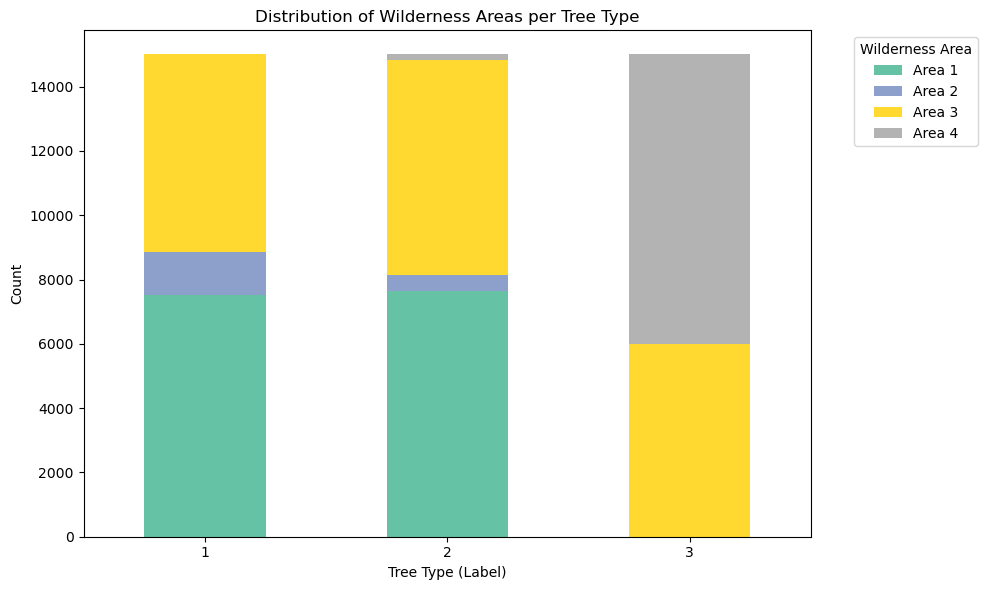

In [37]:
# Calculate total counts of each Wilderness_Area (1–4) per tree type
wilderness_cols = [col for col in df.columns if col.startswith("Wilderness_Area")]
wilderness_counts = df.groupby("label")[wilderness_cols].sum()

# Rename columns for clearer labels
wilderness_counts.columns = [col.replace("Wilderness_Area", "Area ") for col in wilderness_counts.columns]

# Plot: stacked bar chart
plt.figure(figsize=(10, 6))
wilderness_counts.plot(kind="bar", stacked=True, colormap="Set2", figsize=(10, 6))
plt.title("Distribution of Wilderness Areas per Tree Type")
plt.xlabel("Tree Type (Label)")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.legend(title="Wilderness Area", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

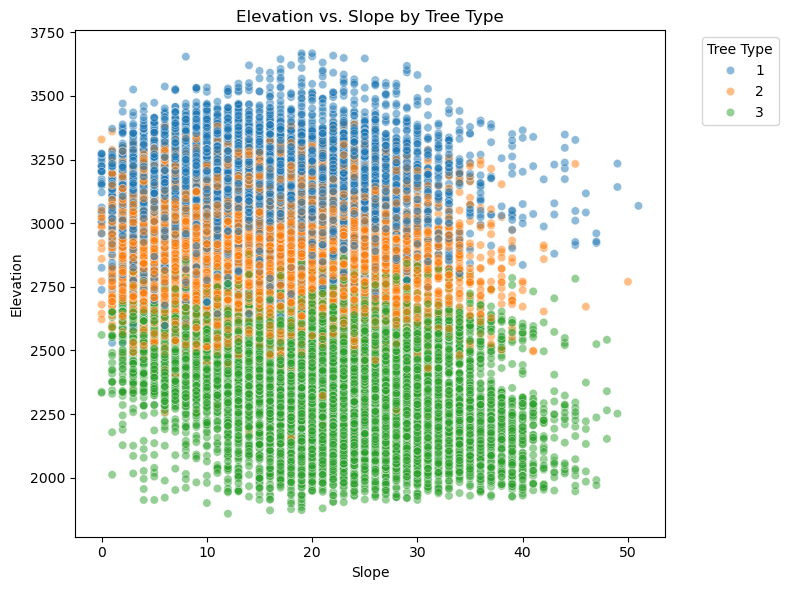

In [42]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x="Slope", y="Elevation", hue="label", palette="tab10", alpha=0.5)
plt.title("Elevation vs. Slope by Tree Type")
plt.xlabel("Slope")
plt.ylabel("Elevation")
plt.legend(title="Tree Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

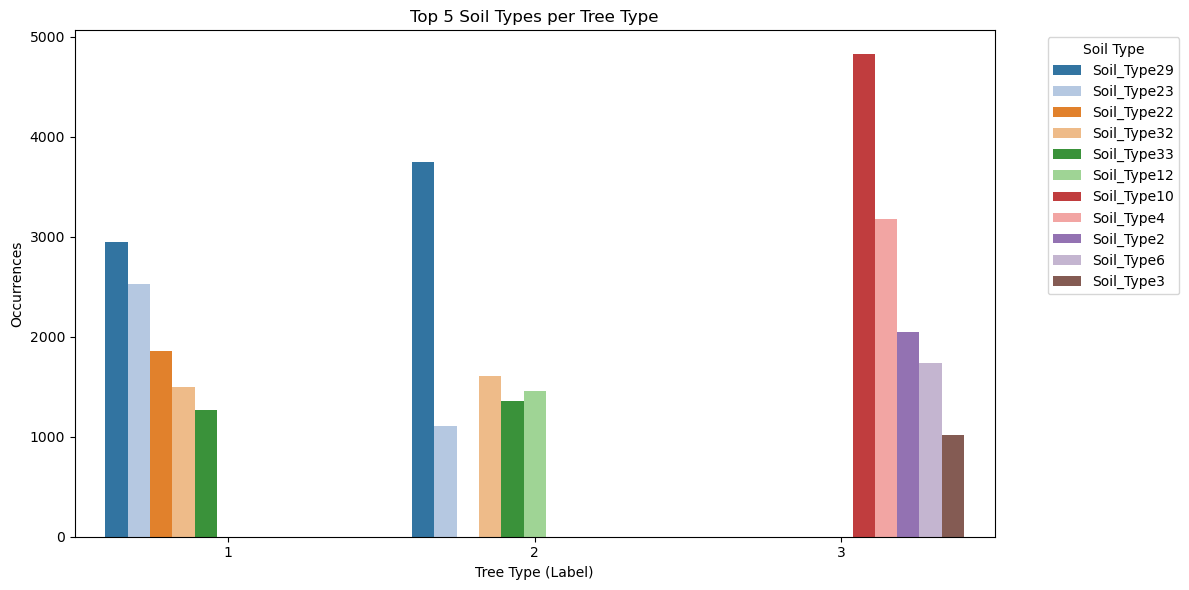

In [35]:
# Prepare the soil usage matrix
soil_cols = [col for col in df.columns if col.startswith("Soil_Type")]
soil_usage = df.groupby("label")[soil_cols].sum()

# Melt the dataframe to long format
soil_usage_long = soil_usage.reset_index().melt(id_vars='label', var_name='Soil_Type', value_name='Count')

# Get top 5 soil types per tree type — updated to avoid the warning
top5_soils_per_label = (
    soil_usage_long
    .sort_values(["label", "Count"], ascending=[True, False])
    .groupby("label", group_keys=False)
    .head(5)
)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=top5_soils_per_label, x="label", y="Count", hue="Soil_Type", palette="tab20")
plt.title("Top 5 Soil Types per Tree Type")
plt.xlabel("Tree Type (Label)")
plt.ylabel("Occurrences")
plt.legend(title="Soil Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

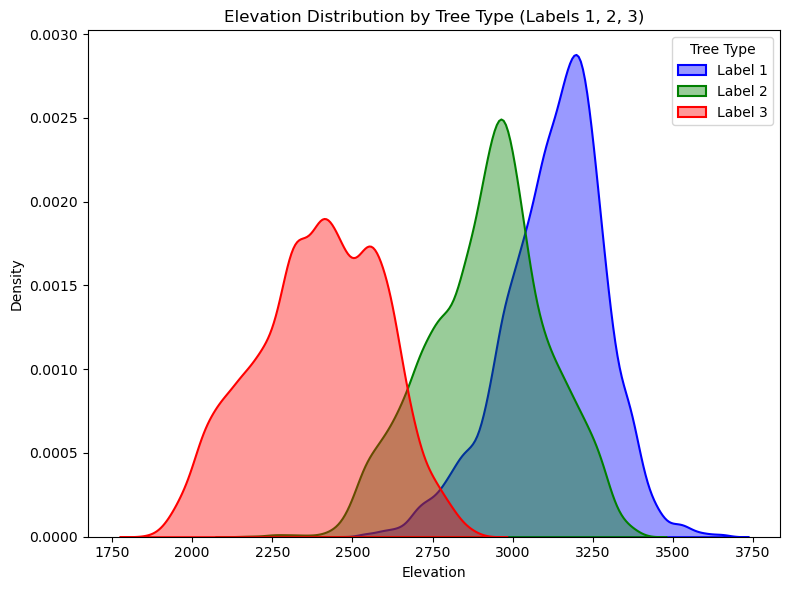

In [72]:
df["Elevation"] = pd.to_numeric(df["Elevation"], errors="coerce")
df_1 = df[df["label"].isin([1, 2, 3])]  # Filter only labels 1, 2, 3
df_1 = df_1.dropna(subset=["Elevation"])  # Remove any null elevation

# Map labels to colors
label_color_map = {1: "blue", 2: "green", 3: "red"}
label_name_map = {1: "Label 1", 2: "Label 2", 3: "Label 3"}

# Plot KDEs manually by label
plt.figure(figsize=(8, 6))
for label in [1, 2, 3]:
    subset = df_1[df_1["label"] == label]
    sns.kdeplot(
        data=subset,
        x="Elevation",
        fill=True,
        alpha=0.4,
        linewidth=1.5,
        color=label_color_map[label],
        label=label_name_map[label]
    )

# Final plot settings
plt.title("Elevation Distribution by Tree Type (Labels 1, 2, 3)")
plt.xlabel("Elevation")
plt.ylabel("Density")
plt.legend(title="Tree Type")
plt.tight_layout()
plt.show()

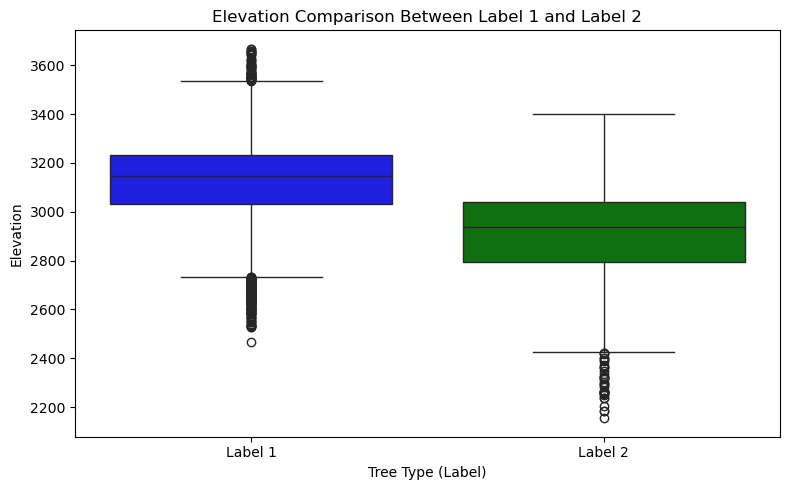

In [79]:
# Filter data for just labels 1 and 2
df_12["label"] = df_1["label"].astype(int)

plt.figure(figsize=(8, 5))
sns.boxplot(
    data=df_12,
    x="label",
    y="Elevation",
    hue="label",   
    palette={1: "blue", 2: "green"},
    legend=False
)

plt.title("Elevation Comparison Between Label 1 and Label 2")
plt.xlabel("Tree Type (Label)")
plt.ylabel("Elevation")
plt.xticks([0, 1], ["Label 1", "Label 2"])
plt.tight_layout()
plt.show()